In [1]:
import pandas as pd
import cobra
from sys import path
path.append("..")
from modules.add_lipids import *
from cobra.core import Metabolite

We may want to add some annotation from bigg:
```python
bigg_metabolites = pd.read_csv("../../data/bigg_models_metabolites.txt", sep="\t")
bigg_reactions = pd.read_csv("../../data/bigg_models_reactions.txt", sep="\t")
```

import requests
url = "https://gitlab.com/digisal/salarecon/-/raw/a3e81f7ffa8fbb014f108234c1489fd347dab4ee/salarecon.xml?inline=false"
response = requests.get(url)
open("salarecon1.xml", "wb").write(response.content)

In [2]:
sasa = cobra.io.read_sbml_model("salarecon1.xml")

In [3]:
sasa

<Model salarecon at 0x1e74e282b50>

In [4]:
sasa.optimize().objective_value

1.613483001639282

In [5]:
mets_before = len(sasa.metabolites)

# Overview  
Lipids are fatty acids connected to backbones. 
Let's deal with the fatty acids first. 

The types of reactions we need to add are:
- Elongation
- Desaturation 
- Beta-oxidation
    This is the way fatty acids are digested, but also unlock some FAs that cannot be synthesized, most notably DHA
- Transport
  - probably by solute carrier family proteins: https://en.wikipedia.org/wiki/Solute_carrier_family
  - https://en.wikipedia.org/wiki/Long-chain_fatty_acid_transport_protein_1
  - https://en.wikipedia.org/wiki/SLC27A3

We will start with a rough outline, and then layer with details when the system is working. 

# Which lipids are the most important?
[Tochter et al](http://dx.doi.org/10.1007/s11745-006-0159-0) have measured FA composition in salmon liver on different diets. 
Aside from EPA and DHA, and linoleic acid for plant based diets, the PUFA content is low, and monoenes have higher values.


# Saturated fatty acids 
can be sythesized through 4 mechanisms according to KEGG:
- FAS 1 (fatty acid synthase)
- FAS 2 (not in animals)
- Fatty acid elongation in mitochondria (len<16)
- Fatty acid elongation in ER (len>16)

# FAS 1
[Fatty acid synthase](https://en.wikipedia.org/wiki/Fatty_acid_synthase) elongates acetyl coa using malonyl coa. 
The wikipedia entry gives an impression that the enzyme holds on to the fatty acid until it is C16:0, but we can just as well put all of them in there. 
This means that there is some overlap with the fatty acid elongation below (acyltransferases), but seems like the elongation is the go-to for usaturated fatty acids, but may just be relevant for the ER version, as the mitochondrial can only make fatty acids of length from 6 to 16, and the desaturases seem to only attack the 16+ ones. 
This complex is well represented in recon, but reaction is lumped up to octanoyl. 
We may want to include all steps.

route a:
- acetyl-CoA + n malonyl-CoA + 2n NADPH + 2n H+ = a long-chain fatty acid + (n+1) CoA + n CO2 + 2n NADP+
    - EC: 2.3.1.85  
  
route b:
- acetyl-CoA + n malonyl-CoA + 2n NADPH + 4n H+ = long-chain-acyl-CoA + n CoA + n CO2 + 2n NADP+ 
  - EC: 2.3.1.86



## Fatty acid elongation in mitochondria (len<16)
Giving these ad hoc ids to make it systematic, based on Cx:y nz (example: C18:1 n3) and step in elongation
- $LCacylcoa + malcoa \rightarrow LC3oxoacylcoa  $
  - EC: 2.3.1.16
  - ad hoc-id: FAEL1{Cxynz}m
- $LC3oxoacylcoa + NADP^+ \rightarrow LChydroxyacylcoa + NADPH  $
  - EC: 1.1.1.35 / 1.1.1.211
  - ad hoc-id: FAEL2_{Cx_y_nz}m
- $LChydroxyacylcoa \rightarrow LCtrans3,2,dehydroxyacylcoa + H_2O  $
  - EC: 4.2.1.17
  - ad hoc-id: FAEL3_{Cx_y_nz}m
- $LCtrans3,2,dehydroxyacylcoa + NADP^+ \rightarrow LCacylcoa + NADPH  $
  - EC: 1.3.1.38
  - ad hoc-id: FAEL4_{Cx_y_nz}m

## Fatty acid elongation in ER (len>16)  
- $LCacylcoa + malcoa \rightarrow LC3oxoacylcoa  $
  - EC: 2.3.1.199
- $LC3oxoacylcoa + NADP^+ \rightarrow LChydroxyacylcoa + NADPH  $
  - EC: 1.1.1.330
- $LChydroxyacylcoa \rightarrow LCtrans3,2,dehydroxyacylcoa + H_2O  $
  - EC: 4.2.1.134
- $LCtrans3,2,dehydroxyacylcoa + NADP^+ \rightarrow LCacylcoa + NADPH  $
  - EC: 1.3.1.93

The simplest route to solve this would be FAS1 + fatty acid elongation in ER.
- copy mets from recon3d
- generate reactions

## Do the intermediate steps matter?
The four step procedure for elongating fatty acids by 2 carbons could be bunched together to one reaction (with an AND rule between the enzymes involved in the separate reactions).  
Pros:  
  - this has largely been done in recon3d etc  
  - we dont have to find the right bigg-ids  
    - reactions/metabolites may not have established ids, but we could use a general format for it  
        leading up to Xcoa could be  
        X3ocoa, X3ohcoa, X2coa, Xcoa 
        the names are referring changes by the pathway...  

Cons:
    - if the intermediates can be used for something else... 
      - in kegg, they are not used for anything else.  
    - How should we annotate the reactions?  
      - the reactions and annotations no longer have the same resolution, so this obscures the reactions.  

- collect kegg reaction and kegg compound, but specific ones are not available for the longer ones. perhaps also the same for 

## Add FAS1 reactions

In [6]:
add_fas1_reactions(sasa)
# note for later: check if it should be 2.3.1.85 or 86...

unknown metabolite 'hxa_c' created
unknown metabolite 'octa_c' created
unknown metabolite 'dca_c' created
unknown metabolite 'ddca_c' created
unknown metabolite 'ttdca_c' created


In [7]:
r = Reaction("hdca_pmtcoa")
sasa.add_reactions([r])
r.reaction = "hdca_c + coa_c <=> pmtcoa_c"

unknown metabolite 'hdca_c' created


^^^ hmmm -- det skulle kanskje ikke skje? vi skal vel ha ttdca --> hdca

In [8]:
sasa.metabolites.hdca_c

<Metabolite hdca_c at 0x1e752eac820>

In [9]:
sasa.metabolites.pmtcoa_c

<Metabolite pmtcoa_c at 0x1e752327c40>

In [10]:
sasa.reactions.hdca_pmtcoa.check_mass_balance()

{'C': 16, 'H': 30, 'O': 1}

## Add ER fatty acid elongation and desaturases

In [11]:
lipids = pd.read_csv("../../data/lipid_metabolites/lipid_metabolites.csv", index_col=0)

In [12]:
lipids

id        id_coa              name  \
C16:0          NaN        pmtcoa               NaN   
C16:1 n7       NaN           NaN               NaN   
C16:2 n7       NaN           NaN               NaN   
C18:0        ocdca         stcoa               NaN   
C18:1 n12      NaN           NaN               NaN   
C18:1 n9       NaN           NaN               NaN   
C18:1 n7       NaN           NaN               NaN   
C18:2 n6       NaN       lnlccoa              lnlc   
C18:3 n6       NaN     lnlncgcoa               NaN   
C18:3 n3       NaN      lnlcacoa               NaN   
C18:4 n3       NaN  3octdectecoa               NaN   
C20:0        arach      arachcoa               NaN   
C20:1 n9       NaN           NaN               NaN   
C20:2 n6       NaN           NaN               NaN   
C20:4 n3       NaN           NaN               NaN   
C20:4 n6       NaN           NaN      arachidonoyl   
C20:3 n6       NaN           NaN               NaN   
C20:3 n3       NaN           NaN               NaN   
C22:0      docosac      docoscoa               NaN   
C22:1 n9       NaN           NaN               NaN   
C20:5 n3       NaN           NaN               NaN   
C22:2 n6       NaN           NaN               NaN   
C24:0          ttc        ttccoa               NaN   
C24:1 n9       NaN           NaN               NaN   
C22:4 n6       NaN           NaN  docosatetraenoyl   
C22:5 n3       NaN           NaN               NaN   
C22:5 n6       NaN           NaN               NaN   
C22:6 n3       NaN           NaN               NaN   
C24:4 n6       NaN    tettet6coa               NaN   
C24:5 n6       NaN   tetpent6coa               NaN   
C24:5 n3       NaN   tetpent3coa               NaN   
C24:6 n3       NaN    tethex3coa               NaN   

                                          name_coa kegg_coa  
C16:0                                          NaN   C00154  
C16:1 n7                                       NaN      NaN  
C16:2 n7                                       NaN      NaN  
C18:0                                          NaN   C00412  
C18:1 n12                                      NaN      NaN  
C18:1 n9                                 oleyl-coa   C00510  
C18:1 n7                                       NaN      NaN  
C18:2 n6                             linoleoyl-coa   C02050  
C18:3 n6                      gamma-linolenoyl-coa   C03035  
C18:3 n3                      alpha-linolenoyl-coa   C16162  
C18:4 n3                    octadecatetraenoyl-coa   C16163  
C20:0                                          NaN      NaN  
C20:1 n9                                       NaN      NaN  
C20:2 n6                                       NaN      NaN  
C20:4 n3           8z11z14z17z-icosatetraenoyl-coa   C16164  
C20:4 n6                           arachidonoylcoa   C02249  
C20:3 n6                                       NaN      NaN  
C20:3 n3               11z14z17z-icosatrienoyl-coa   C16179  
C22:0                                          NaN      NaN  
C22:1 n9                                       NaN      NaN  
C20:5 n3                                       NaN      NaN  
C22:2 n6                                       NaN      NaN  
C24:0                                          NaN      NaN  
C24:1 n9                                       NaN      NaN  
C22:4 n6                                       NaN   C16170  
C22:5 n3                                       NaN      NaN  
C22:5 n6        4z7z10z13z16z-docosapentaenoyl-coa   C16173  
C22:6 n3       4z7z10z13z16z19zdocosahexaenoyl-coa   C16169  
C24:4 n6                                       NaN   C16171  
C24:5 n6     6z9z12z15z18z-tetracosapentaenoyl-coa   C16172  
C24:5 n3     9z12z14z18z21z-tetracospentaenoyl-coa   C16167  
C24:6 n3   6z9z12z15z18z21z-tetracosahexaenoyl-coa   C16168

Add free fatty acids and fatty acid coas for each lipid in the dataframe above.

In [13]:
add_fatty_acid_metabolites(sasa)

In [14]:
sasa.metabolites.C226n3_c

<Metabolite C226n3_c at 0x1e752ee4760>

Add hydrolase reaction:

In [15]:
for fa in lipids.index:
    fa_r = Reaction(f"HYD{get_free_fatty_acyl_id(fa)}")
    sasa.add_reactions([fa_r])
    fa_r.reaction = fatty_acyl_coa_hydrolase(fa, "c")

In [16]:
sasa

<Model salarecon at 0x1e74e282b50>

In [17]:
get_elongation_mid_product_ids("p_id")

['3op_id', '3hp_id', 'p_id']

Add ferri/ferrocytochrome b5

In [18]:
for key, val in {"focytb5":  "C00999", "ficytb5": "C00996"}.items():
    met = Metabolite(f"{key}_r", "X")
    met.annotation["kegg.compound"] = val
    sasa.add_metabolites([met])

Add fatty acid synthesis reactions:

In [19]:
add_fatty_acid_reactions(sasa)

unknown metabolite 'malcoa_r' created
unknown metabolite 'h_r' created
unknown metabolite 'coa_r' created
unknown metabolite 'co2_r' created
unknown metabolite 'nadph_r' created
unknown metabolite 'nadp_r' created
unknown metabolite 'h2o_r' created
unknown metabolite 'o2_r' created


In [20]:
sasa

<Model salarecon at 0x1e74e282b50>

## Add transport between cytosol and ER + metabolite.compartment  
Transport of all of the long chain fatty acids between cytosol and endoplasmic reticulum was added, as well as the supporting metabolites such as nadp+/h, h2o and malcoa and coa. 
It is likely that some of this should be omitted eventually, to get the fa-synthesis going...  
- How is NADP+/H metabolism working in ER?

In [21]:
for met in sasa.metabolites[mets_before:]:
    if f"{met.id[:-2].upper()}tr" in sasa.reactions:
        continue
    if met.id.endswith("r"):
        rxntr = cobra.Reaction(id=f"{met.id[:-2].upper()}tr")
        sasa.add_reactions([rxntr])
        rxntr.reaction = f"{met.id[:-2]}_c <=> {met.id[:-2]}_r"

unknown metabolite 'focytb5_c' created
unknown metabolite 'ficytb5_c' created
unknown metabolite '3ostcoa_c' created
unknown metabolite '3hstcoa_c' created
unknown metabolite 'st2coa_c' created
unknown metabolite '3oC181n7coa_c' created
unknown metabolite '3hC181n7coa_c' created
unknown metabolite 'C181n72coa_c' created
unknown metabolite '3oarachcoa_c' created
unknown metabolite '3harachcoa_c' created
unknown metabolite 'arach2coa_c' created
unknown metabolite '3oC201n9coa_c' created
unknown metabolite '3hC201n9coa_c' created
unknown metabolite 'C201n92coa_c' created
unknown metabolite '3oC202n6coa_c' created
unknown metabolite '3hC202n6coa_c' created
unknown metabolite 'C202n62coa_c' created
unknown metabolite '3oC203n6coa_c' created
unknown metabolite '3hC203n6coa_c' created
unknown metabolite 'C203n62coa_c' created
unknown metabolite '3oC203n3coa_c' created
unknown metabolite '3hC203n3coa_c' created
unknown metabolite 'C203n32coa_c' created
unknown metabolite '3oC204n3coa_c' create

In [22]:
sasa

<Model salarecon at 0x1e74e282b50>

In [23]:
sasa.optimize()

<Solution 1.613 at 0x1e752f380d0>

## Add long-chain fatty acids to to biomass  
Add fatty acids to biomass. 
Adding all to biomass will serve to check that all can be synthesized, allthough it is not totally realistic. 
Adding a lipid composition from data will be more realistic, but can leave some lipids useless as long as the model does not represent degradation/beta oxidation of lipids well.  

In [24]:
# add all:
fat = [get_fatty_acyl_coa_id(fa) for fa in lipids.index] # if "n" not in fa]
sat = {f"{met}_c": -1 for met in fat if f"{met}_c" in sasa.metabolites}
sasa.reactions.Lipids_biomass.add_metabolites(sat)
# the number is arbitrary as the mass is not taken into account yet.

In [25]:
sasa.optimize()

<Solution 0.000 at 0x1e752f38910>

### Which lipids can be synthesized?

<AxesSubplot:>

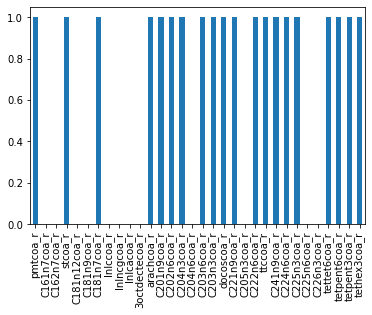

In [26]:
lipid_dict1 = dict()
with sasa as model:
    for lipid in lipids.index:
        l_id = f"{get_fatty_acyl_coa_id(lipid)}_r"
        if l_id not in model.metabolites:
            print(l_id)
            continue
        r = Reaction(f"dm{l_id}")
        model.add_reaction(r)
        r.reaction = f"{l_id} --> coa_c"
        r.bounds = -1, 1
        #model.add_boundary(model.metabolites.get_by_id(l_id), "demand")
        model.objective = r.id
        lipid_dict1[l_id] = model.optimize().objective_value
pd.Series(lipid_dict1).plot.bar()

### Which can be synthesized with the supply of esesntial fatty acids?

In [27]:
# add supply of essentail fatty acids
for l in "C18:3 n3, C20:5 n3, C18:2 n6, C20:4 n6".split(", "):
    l_id = f"{get_fatty_acyl_coa_id(l)}_r"
    r = Reaction(f"sk{l_id}")
    sasa.add_reaction(r)
    r.reaction = f"{l_id} <-- coa_c"
    r.bounds = -1, 1
    #sasa.add_boundary(sasa.metabolites.get_by_id(f"{get_fatty_acyl_coa_id(l)}_r"), "sink")


<AxesSubplot:>

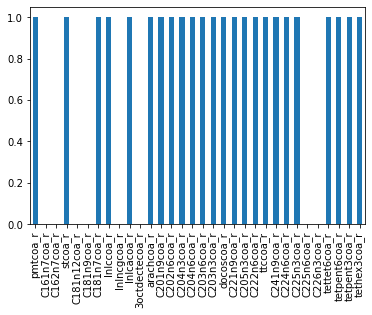

In [28]:
lipid_dict2 = dict()
with sasa as model:
    for lipid in lipids.index:
        l_id = f"{get_fatty_acyl_coa_id(lipid)}_r"
        if l_id not in model.metabolites:
            print(l_id)
            continue
        r = Reaction(f"dm{l_id}")
        model.add_reaction(r)
        r.reaction = f"{l_id} --> coa_c"
        r.bounds = -1, 1
        #model.add_boundary(model.metabolites.get_by_id(l_id), "demand")
        model.objective = r.id
        lipid_dict2[l_id] = model.optimize().objective_value
pd.Series(lipid_dict2).plot.bar()

### Desaturases depend on ferrocytochrome/ferricytochrome

In [29]:
r = Reaction("FIB5RED")
sasa.add_reactions([r])
r.reaction = "nadph_r + 2 ficytb5_r --> nadp_r + h_r + 2 focytb5_r"

<AxesSubplot:>

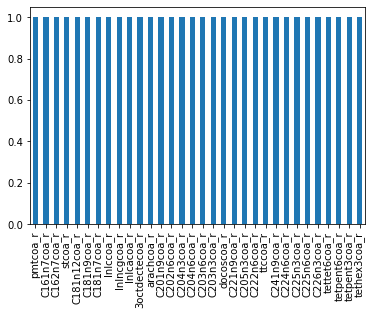

In [30]:
lipid_dict3 = dict()
with sasa as model:
    for lipid in lipids.index:
        l_id = f"{get_fatty_acyl_coa_id(lipid)}_r"
        if l_id not in model.metabolites:
            print(l_id)
            continue
        r = Reaction(f"dm{l_id}")
        model.add_reaction(r)
        r.reaction = f"{l_id} --> coa_c"
        r.bounds = -1, 1
        #model.add_boundary(model.metabolites.get_by_id(l_id), "demand")
        model.objective = r.id
        lipid_dict3[l_id] = model.optimize().objective_value
pd.Series(lipid_dict3).plot.bar()

In [31]:
sol = sasa.optimize()
sol

<Solution 0.094 at 0x1e7543d81f0>

### Can we use real data?

In [32]:
with sasa as model:
    df = pd.read_csv(data_path + "measured_lipids.csv", index_col=0)
    bm_dict = dict()
    for name in df[~df.Fosol.isna()].Fosol.index:
        if name not in lipids.index:
            print(name)
            continue
        try:
            bm_dict[get_fatty_acyl_coa_id(name) + "_c"] = - df.Fosol[name]
        except KeyError:
            print(":(")
    model.reactions.Lipids_biomass.reaction = "--> Lipids_c"
    model.reactions.Lipids_biomass.add_metabolites(bm_dict)
    test_sol = model.optimize()
    test_blocked = cobra.flux_analysis.find_blocked_reactions(model)
test_sol

C22:1 n11


<Solution 0.033 at 0x1e75450ffa0>

Yes, but we don't have every possible lipid represented.  
As mentioned above, not including all fatty acids in biomass will make some of them look redundant, as the present model does not degrade them (stay tuned):

In [33]:
len(test_blocked)

208

In [34]:
for met in sasa.metabolites:
    if met.compartment:
        continue
    met.compartment = met.id[-1]

In [35]:
blocked = cobra.flux_analysis.find_blocked_reactions(sasa)

In [36]:
len(blocked)

129

The blocked reactions of the model with all lipids in has some blocked reactions, but those are redundant transport reactions:

In [37]:
blocked

['FAS60COA',
 'FAS80COA',
 'FAS100COA',
 'FAS120COA',
 'FAS140COA',
 'hdca_pmtcoa',
 'HYDC160',
 'HYDC161n7',
 'HYDC162n7',
 'HYDocdca',
 'HYDC181n12',
 'HYDC181n9',
 'HYDC181n7',
 'HYDC182n6',
 'HYDC183n6',
 'HYDC183n3',
 'HYDC184n3',
 'HYDarach',
 'HYDC201n9',
 'HYDC202n6',
 'HYDC204n3',
 'HYDC204n6',
 'HYDC203n6',
 'HYDC203n3',
 'HYDdocosac',
 'HYDC221n9',
 'HYDC205n3',
 'HYDC222n6',
 'HYDttc',
 'HYDC241n9',
 'HYDC224n6',
 'HYDC225n3',
 'HYDC225n6',
 'HYDC226n3',
 'HYDC244n6',
 'HYDC245n6',
 'HYDC245n3',
 'HYDC246n3',
 'C160tr',
 'C161N7tr',
 'C162N7tr',
 'OCDCAtr',
 'C181N12tr',
 'C181N9tr',
 'C181N7tr',
 'C182N6tr',
 'C183N6tr',
 'C183N3tr',
 'C184N3tr',
 'ARACHtr',
 'C201N9tr',
 'C202N6tr',
 'C204N3tr',
 'C204N6tr',
 'C203N6tr',
 'C203N3tr',
 'DOCOSACtr',
 'C221N9tr',
 'C205N3tr',
 'C222N6tr',
 'TTCtr',
 'C241N9tr',
 'C224N6tr',
 'C225N3tr',
 'C225N6tr',
 'C226N3tr',
 'C244N6tr',
 'C245N6tr',
 'C245N3tr',
 'C246N3tr',
 'FOCYTB5tr',
 'FICYTB5tr',
 '3OSTCOAtr',
 '3HSTCOAtr',
 'ST2C

In [38]:
# sasa.remove_reactions(blocked)

In [39]:
sasa

<Model salarecon at 0x1e74e282b50>

In [40]:
sasa_met_rxns = {met.id: len(met.reactions) for met in sasa.metabolites}

In [41]:
"""for met, n_rxns in sasa_met_rxns.items():
    if not n_rxns:
        sasa.metabolites.get_by_id(met).remove_from_model()"""

'for met, n_rxns in sasa_met_rxns.items():\n    if not n_rxns:\n        sasa.metabolites.get_by_id(met).remove_from_model()'

In [42]:
[m for m in sasa.metabolites if not m.formula]

[<Metabolite DNA_n at 0x1e7523a2940>,
 <Metabolite DNA_c at 0x1e7523a2820>,
 <Metabolite Carbohydrates_c at 0x1e7523a2f70>,
 <Metabolite Lipids_c at 0x1e7523a22b0>,
 <Metabolite RNA_c at 0x1e7523a2370>,
 <Metabolite Protein_c at 0x1e75240fd30>,
 <Metabolite hxa_c at 0x1e752e8daf0>,
 <Metabolite octa_c at 0x1e752e8db80>,
 <Metabolite dca_c at 0x1e752e8de50>,
 <Metabolite ddca_c at 0x1e74698f490>,
 <Metabolite ttdca_c at 0x1e752e8dfa0>,
 <Metabolite hdca_c at 0x1e752eac820>,
 <Metabolite malcoa_r at 0x1e752ef5df0>,
 <Metabolite h_r at 0x1e752ef5dc0>,
 <Metabolite coa_r at 0x1e752ef5be0>,
 <Metabolite co2_r at 0x1e752ef5f10>,
 <Metabolite nadph_r at 0x1e752efd130>,
 <Metabolite nadp_r at 0x1e752efd280>,
 <Metabolite h2o_r at 0x1e752efd5e0>,
 <Metabolite o2_r at 0x1e752efdc10>,
 <Metabolite focytb5_c at 0x1e752f4ff40>,
 <Metabolite ficytb5_c at 0x1e752f4fd90>,
 <Metabolite 3ostcoa_c at 0x1e752f542e0>,
 <Metabolite 3hstcoa_c at 0x1e752f54b80>,
 <Metabolite st2coa_c at 0x1e752f57130>,
 <Meta

In [43]:
sasa.metabolites.C226n3_c

<Metabolite C226n3_c at 0x1e752ee4760>

In [44]:


get_elemental_composition_from_siblings(sasa)

In [45]:
sasa.metabolites.C226n3_c

<Metabolite C226n3_c at 0x1e752ee4760>

In [46]:
len([m for m in sasa.metabolites if not m.formula])

12

In [47]:
len([m for m in sasa.metabolites if not m.formula])

12

In [48]:
{m for m in sasa.metabolites if not m.formula}

{<Metabolite Carbohydrates_c at 0x1e7523a2f70>,
 <Metabolite DNA_c at 0x1e7523a2820>,
 <Metabolite DNA_n at 0x1e7523a2940>,
 <Metabolite Lipids_c at 0x1e7523a22b0>,
 <Metabolite Protein_c at 0x1e75240fd30>,
 <Metabolite RNA_c at 0x1e7523a2370>,
 <Metabolite dca_c at 0x1e752e8de50>,
 <Metabolite ddca_c at 0x1e74698f490>,
 <Metabolite hdca_c at 0x1e752eac820>,
 <Metabolite hxa_c at 0x1e752e8daf0>,
 <Metabolite octa_c at 0x1e752e8db80>,
 <Metabolite ttdca_c at 0x1e752e8dfa0>}

In [49]:
"""for fa in lipids.index:
    fa_r = Reaction(f"HYD{get_free_fatty_acyl_id(fa)}")
    sasa.add_reactions([fa_r])
    fa_r.reaction = fatty_acyl_coa_hydrolase(fa, "c")"""

'for fa in lipids.index:\n    fa_r = Reaction(f"HYD{get_free_fatty_acyl_id(fa)}")\n    sasa.add_reactions([fa_r])\n    fa_r.reaction = fatty_acyl_coa_hydrolase(fa, "c")'

In [50]:
sasa.metabolites.C226n3_c

<Metabolite C226n3_c at 0x1e752ee4760>

In [51]:
infer_metabolite_formulae_from_reaction_balance(sasa)

In [52]:
sasa.metabolites.C226n3_c

<Metabolite C226n3_c at 0x1e752ee4760>

In [53]:
sasa.reactions.Lipids_biomass.reaction = " + ".join([f"{get_free_fatty_acyl_id(l)}_c" for l in lipids.index]) + " --> Lipids_c"

In [54]:
sasa.reactions.Lipids_biomass.reaction

'C160_c + C161n7_c + C162n7_c + C181n12_c + C181n7_c + C181n9_c + C182n6_c + C183n3_c + C183n6_c + C184n3_c + C201n9_c + C202n6_c + C203n3_c + C203n6_c + C204n3_c + C204n6_c + C205n3_c + C221n9_c + C222n6_c + C224n6_c + C225n3_c + C225n6_c + C226n3_c + C241n9_c + C244n6_c + C245n3_c + C245n6_c + C246n3_c + arach_c + docosac_c + ocdca_c + ttc_c --> Lipids_c'

In [55]:
sasa.optimize()

<Solution 0.135 at 0x1e754802e20>

In [56]:
blocked = cobra.flux_analysis.find_blocked_reactions(sasa)

In [57]:
for r in blocked:
    print(sasa.reactions.get_by_id(r).reaction)

12dgr160_c + cdpchol_c --> cmp_c + h_c + pc160_c
atp_c + chol_c --> adp_c + cholp_c + h_c
cholp_c + ctp_c + h_c --> cdpchol_c + ppi_c
1hdecg3p_c + pmtcoa_c --> coa_c + pa160_c
glyc3p_c + pmtcoa_c --> 1hdecg3p_c + coa_c
h2o_c + pa160_c --> 12dgr160_c + pi_c
but_c + 2.0 h_c + malcoa_c + 2.0 nadph_c --> co2_c + coa_c + hxa_c + 2.0 nadp_c
2.0 h_c + hxa_c + malcoa_c + 2.0 nadph_c --> co2_c + coa_c + 2.0 nadp_c + octa_c
2.0 h_c + malcoa_c + 2.0 nadph_c + octa_c --> co2_c + coa_c + dca_c + 2.0 nadp_c
dca_c + 2.0 h_c + malcoa_c + 2.0 nadph_c --> co2_c + coa_c + ddca_c + 2.0 nadp_c
ddca_c + 2.0 h_c + malcoa_c + 2.0 nadph_c --> co2_c + coa_c + 2.0 nadp_c + ttdca_c
coa_c + hdca_c <=> pmtcoa_c
C160_c <=> C160_r
C161n7_c <=> C161n7_r
C162n7_c <=> C162n7_r
ocdca_c <=> ocdca_r
C181n12_c <=> C181n12_r
C181n9_c <=> C181n9_r
C181n7_c <=> C181n7_r
C182n6_c <=> C182n6_r
C183n6_c <=> C183n6_r
C183n3_c <=> C183n3_r
C184n3_c <=> C184n3_r
arach_c <=> arach_r
C201n9_c <=> C201n9_r
C202n6_c <=> C202n6_r
C204n3_

In [58]:
sasa.reactions.Lipids_biomass.add_metabolites({sasa.metabolites.pa160_c: -1})

In [59]:
sasa.optimize()

<Solution 0.135 at 0x1e75483a220>

In [60]:
blocked = cobra.flux_analysis.find_blocked_reactions(sasa)
sasa.remove_reactions(blocked)
sasa

<Model salarecon at 0x1e74e282b50>

In [61]:
for m in sasa.metabolites: 
    if not len(m.reactions):
        m.remove_from_model()

In [62]:
sasa

<Model salarecon at 0x1e74e282b50>

In [63]:
for metabolite in sasa.metabolites:
    if not metabolite.compartment:
        metabolite.compartment = metabolite.id[-1]

In [64]:
sasa.repair()

In [65]:
cobra.io.write_sbml_model(sasa, "../../salarecon.xml")
cobra.io.write_sbml_model(sasa, "../../data/models/sasa/salarecon.xml")

In [66]:
[r for r in sasa.reactions if len(r.compartments) == 1 and len(r.metabolites) > 1 and len(r.check_mass_balance())]

[<Reaction DNA_biomass at 0x1e752d336d0>,
 <Reaction RNA_biomass at 0x1e752d33580>,
 <Reaction Lipids_biomass at 0x1e752d33ca0>,
 <Reaction Protein_biomass at 0x1e752d33d00>,
 <Reaction Carbohydrates_biomass at 0x1e752d33dc0>]

### Further annotation + genes from kegg  
this is a work in progress...

Using autokeggrec, an automatic reconstruction based on kegg (omitting metabolites with R-groups and so fourth...), we can get a lot of annotation in terms of kegg.reaction, kegg.compound, ec-code and genes.  
The genes should be compartmentalized based on wolfpsort results.  

One plan could be to connect the dots by combining C-codes and EC codes to find R-codes, R-codes being corresponding to COBRA reactions.  
Not all reactions or metabolites will have R or C codes, as kegg is more general about larger fatty acids.
The autokeggrec model can also be used for reference for elememental composition, but kegg does not have charged compounds, so protons will have to be removed (1 for free fatty acids for instance)

In [73]:
ak = cobra.io.read_sbml_model("../../data/models/sasa/auto/sasa_autokeggrec.xml")

No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized


In [142]:
# not getting all ecs, but almost
d = dict()
for r in ak.reactions:
    ec = r.annotation.get("ec-code")
    if type(ec) == str:
        ec = ec.split(" ")
    if type(ec) == list:
        for e in ec:
            if type(e) == str:
                d[e] = r.gene_reaction_rule

In [162]:
sasa = cobra.io.read_sbml_model("../../salarecon.xml")

In [164]:
len(sasa.genes)
missing_a = [r.id for r in sasa.reactions if not r.genes]

In [165]:
l = list()

for r in sasa.reactions:
    if r.genes:
        continue
    r_rule_list = list()
    ec = r.annotation.get("ec-code", False)
    if type(ec) == list:
        l += ec
        for e in ec:
            rule = d.get(e)
            if rule:
                r_rule_list.append(rule)
    if type(ec) == str:
        l.append(ec)
        rule = d.get(e)
        if rule:
            r_rule_list.append(rule)
    if r_rule_list:
        if len(r_rule_list) > 1:
            r.gene_reaction_rule = f"( {' ) or ( '.join([rule for rule in r_rule_list])} )"
        if len(r_rule_list) == 1:
            r.gene_reaction_rule = r_rule_list[0]

In [166]:
missing_b = [r.id for r in sasa.reactions if not r.genes]

In [174]:
[r for r in missing_a if r not in missing_b]

['3SPYRSP',
 'NNOR',
 'NaKt',
 'ATPS1',
 'PDHe2r',
 'AADSACYCL',
 'PACCOAL',
 'PHACCOAGLNAC',
 'DUTPDP',
 'HMGCOASm']

In [161]:
len(sasa.genes)

1146

In [156]:
len([r for r in sasa.reactions if r.genes])

500

In [159]:
sasa

<Model salarecon at 0x1e8316864f0>

In [150]:
{i: d.get(i) for i in l if d.get(i)}

{'1.6.1.1': '106562460 or 106562504 or 106562428 or 106568155 or 106587679 or 106587682',
 '1.6.1.2': '106562460 or 106562504 or 106562428 or 106568155 or 106587679 or 106587682',
 '1.6.1.3': '106562460 or 106562504 or 106562428 or 106568155 or 106587679 or 106587682',
 '2.3.1.12': '106603064 or 106604067 or 106563586 or 106563967 or 106566255 or 106561021 or 106579465 or 106583814 or 106593429 or 106584548 or 106590467',
 '1.1.1.42': '106582376 or 106591778 or 106598629 or 106598461 or 106586335 or 100194639 or 100194640 or 106588118 or 106598572 or 106591218',
 '1.5.1.3': '100196879 or 106573293',
 '1.8.1.7': '106604481',
 '1.2.1.31': '100194754',
 '1.4.1.18': '100194754',
 '1.14.17.1': '106568424',
 '1.2.1.18': '106592678 or 106571571 or 100217349',
 '3.1.2.4': '106586135',
 '1.2.1.32': '106608358',
 '3.6.1.-': '106562484 or 106562547',
 '3.6.1.23': '106562484 or 106562547',
 '3.6.1.9': '100380852 or 106571209 or 106588363',
 '2.3.3.10': '106571543'}

In [112]:
old = cobra.io.read_sbml_model("../../data/models/sasa/old/Salmo_salar.xml")

In [113]:
ol = list()

for r in sasa.reactions:
    # if r.genes:
    #     continue
    ec = r.annotation.get("ec-code", False)
    if type(ec) == list:
        ol += ec
    if type(ec) == str:
        ol.append(ec)

In [145]:
len([i for i in ol if d.get(i)])

543

In [96]:
for r in sasa.reactions:
    if r.genes:
        continue
    ec = r.annotation.get("ec-code")
    if type(ec) == list:
        gpr_list = list()
        for e in ec:
            gpr = d.get(e, False)
            if gpr:
                gpr_list.append(gpr)
        if gpr_list:
            gpr = "( " + " ) or ( ".join(gpr_list) + " )"
    if type(ec) == str:
        gpr = d.get(ec, False)
    if gpr:
        # r.gene_reaction_rule = gpr
        print(gpr)

In [85]:
d

{'3.6.1.1': '106560865 or 106602282 or 106610351 or 106610355 or 106577390 or 106577348 or 106577215 or 106592890 or 106608436',
 '1.11.1.6 1.11.1.21': '106586175 or 106564824 or 100195273',
 '3.2.1.28': '106613396 or 106613397',
 '1.2.4.1 2.2.1.6 4.1.1.1': '106603064 or 106563586 or 106566255 or 106579465 or 106583814 or 106593429 or 106590467',
 '3.2.1.52': '106568911 or 106601782 or 106606695 or 100195429 or 100196605 or 106589463',
 '3.2.1.21': '106577614',
 '3.2.1.20': '106595381 or 106593024 or 106601771 or 106613210 or 106564132 or 106588841',
 '1.10.3.1 1.14.18.1': '100136546 or 106569882 or 106588324',
 '1.13.11.63': '106562095 or 101448035 or 101448034',
 '4.2.1.24': '106563307 or 100195823',
 '1.14.13.- 1.17.3.2': '100380763',
 '1.16.3.1': '106560591 or 106570805 or 100194686',
 '2.5.1.61': '106602870 or 106612480',
 '3.6.1.5': '106579923 or 106605417 or 106565347 or 106577463 or 106583547 or 106592522',
 '3.6.1.3 3.6.1.5 3.6.1.8 3.6.1.15': '106580000 or 106579923 or 1066054

In [ ]:
[print(r) for r in ak.metabolites.get_by_id("C00249[c]").reactions]

R01280: C00002[c] + C00010[c] + C00249[c] <=> C00013[c] + C00020[c] + C00154[c]
R01274: C00001[c] + C00154[c] <=> C00010[c] + C00249[c]


[None, None]

In [ ]:
ak.reactions.R08176

<Reaction R08176 at 0x1b3f5792c70>

In [ ]:
[r for r in ak.metabolites.get_by_id("C00712[c]").reactions]

[<Reaction R09537 at 0x1b3f58d4820>, <Reaction R08176 at 0x1b3f5792c70>]

In [ ]:
ak.metabolites.get_by_id("C00510[c]")

<Metabolite C00510[c] at 0x1b3f35ab8e0>

In [ ]:
sasa.metabolites.get_by_id(get_fatty_acyl_coa_id("C18:1 n9")+"_c")

<Metabolite C181n9coa_c at 0x1b3f1ea9160>

In [ ]:
[met.name for met in ak.metabolites if met.elements.get("C") == 38]

[' Palmitoyl-CoA; Hexadecanoyl-CoA ',
 ' 3-Hexaprenyl-4,5-dihydroxybenzoate ',
 ' (S)-3-Hydroxyhexadecanoyl-CoA ',
 ' 3-Oxopalmitoyl-CoA; 3-Ketopalmitoyl-CoA; 3-Oxohexadecanoyl-CoA ',
 ' trans-Hexadec-2-enoyl-CoA; trans-2-Hexadecenoyl-CoA; (2E)-Hexadecenoyl-CoA ',
 ' 2-Hexaprenyl-6-methoxy-1,4-benzoquinone ',
 ' 4,8,12-Trimethyltridecanoyl-CoA ',
 ' 3-Hexaprenyl-4-hydroxybenzoate; 3-Hexaprenyl-4-hydroxybenzoic acid ',
 ' OPC6-CoA ',
 ' trans-2-Enoyl-OPC6-CoA ',
 ' 3-Hydroxy-OPC6-CoA ',
 ' 3-Oxo-OPC6-CoA ']

In [ ]:
ak.metabolites.get_by_id(f"{lipids.iloc[0].kegg_coa}[c]").elements

{'C': 38,
 'H': 66,
 'N': 7,
 'O': 17,
 'P': 3,
 'S': 1,
 'E': 1,
 'X': 1,
 'A': 1,
 'T': 1}

In [ ]:
{r.id: {met.name: met.id for met in r.metabolites.keys()} for r in ak.reactions if r.annotation.get("ec-code") == '3.1.2.2'}

{'R08174': {' H2O; Water ': 'C00001[c]',
  ' Stearoyl-CoA; Stearyl-CoA; Stearyl coenzyme A ': 'C00412[c]',
  ' CoA; Coenzyme A; CoA-SH ': 'C00010[c]',
  ' Octadecanoic acid; Stearate; Stearic acid ': 'C01530[c]'},
 'R08175': {' H2O; Water ': 'C00001[c]',
  ' Eicosanoyl-CoA; Icosanoyl-CoA; Arachidoyl-CoA ': 'C02041[c]',
  ' CoA; Coenzyme A; CoA-SH ': 'C00010[c]',
  ' Icosanoic acid; Eicosanoic acid; Arachidic acid ': 'C06425[c]'},
 'R08176': {' H2O; Water ': 'C00001[c]',
  ' Oleoyl-CoA; (9Z)-Octadecenoyl-CoA ': 'C00510[c]',
  ' CoA; Coenzyme A; CoA-SH ': 'C00010[c]',
  ' (9Z)-Octadecenoic acid; (Z)-Octadec-9-enoic acid; Oleate; Oleic acid ': 'C00712[c]'},
 'R08177': {' H2O; Water ': 'C00001[c]',
  ' Linoleoyl-CoA; (9Z,12Z)-Octadecadienoyl-CoA ': 'C02050[c]',
  ' CoA; Coenzyme A; CoA-SH ': 'C00010[c]',
  ' Linoleate; Linoleic acid; (9Z,12Z)-Octadecadienoic acid; 9-cis,12-cis-Octadecadienoate; 9-cis,12-cis-Octadecadienoic acid ': 'C01595[c]'},
 'R08178': {' H2O; Water ': 'C00001[c]',
  ' 

In [ ]:
reactions = pd.read_csv("../../data/lipid_metabolites/lipid_reactions.csv")

In [ ]:
[r.name for r in ak.reactions if r.annotation.get("ec-code") == reactions.iloc[15].ec]

['octadecanoyl-CoA:NADP+ trans-2-oxidoreductase']

# Desaturating fatty acids  
There are many combinations available, but which ones are not?  
Is starting out with the KEGG maps sufficient, or could any bond that has not already been desaturated be targeted by a desaturase? 

The desaturases are either $\Delta 6$ ([EC 1.14.19.3](https://www.genome.jp/entry/1.14.19.3)) or $\Delta 9$ ([EC 1.14.19.1](https://www.genome.jp/entry/1.14.19.1)), but the desaturated fatty acids can be elongated in the same way as unsaturated fatty acids.

Kegg claims $\Delta 8$ to also be possible (using the $\Delta 6$ elongase). However, elongation --> $\Delta 8$ is equivalent to $\Delta 6$ --> elongation, and these processes are catalyzed by the same enzymes, so this may not be neccesary to include, unless there are a lot of the intermediate in the prior "pathway" in the feed or something like that.  

Note: the UFAs are grouped into families in the kegg map, depending on the length of the chain following the last double bond (so, $length_{FA} - higest \Delta$) 
For instance, C16$\Delta 6$ aka C16n-10 is in the n-10 family.  
This "family property" is conserved through elongation.  
n-10 family stems from $\Delta 6$ desaturation of C16, n-9 from $\Delta 9$ desaturation of C18, n-7 from $\Delta 9$ on C16. 

Note on n-7: why isn't the $\Delta 6$ desaturase working on C16$\Delta 9$?  
There isnt a connected reaction or EC-number in the reference pathway. 
Maybe there is a reason for this, but if the reaction is possible in any organism, it should be associated to a reaction. 

There also seems to be genes for the $\Delta 5$ desaturase *$\Delta 5fads2$*. 
This desaturase has been in focus for Jin and Datsomor   
![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-019-53316-w/MediaObjects/41598_2019_53316_Fig1_HTML.png?as=webp)

The general mechanism for desaturation of a fatty acid is  
$FA + 2 ferrocytochrome_{b5} + O_2 + 2 H^+ \Rightarrow FA_{desaturated} + 2 ferricytochrome_{b5} + 2 H_2O$  
ferrocytochrome/ferricytochrome can be reduced by NAD:  
$NADH + 2 ferricytochrome_{b5} <=> NAD^+ + 2 ferrocytochrome_{b5} + H^+$  
or by vitamin C:  
$L \text{-} ascorbate + ferricytochrome_{b5} → monodehydroascorbate + ferrocytochrome_{b5}$  

ferrocytochrome b5 is also involved in NeuGC, a glycoprotein sugar

In recon, however, the ferrocytochrome is substituted with NADPH, which shouldn't really make a difference as long as the formula is balanced.
ferrocytochrome is called HC00619 in Recon3D, but focytb5 has better annotation,  
vice versa for  HC00617 and ficytb5

In [ ]:
def fa_desaturation_reaction(fa, desaturated_fa, ec='', kegg_reaction=''):
    return f"h_c + nadph_c + o2_c + {fa} --> 2 h2o_c + nadp_c + {desaturated_fa}"

In [ ]:
# Elongation of fatty acids is the same mechanism for saturated and unsaturated fatty acids, so the previous lcfa_elongation() may not be satisfactory...
# note: in the "Unsaturated fatty acids-map" in kegg, the elongation step has an arrow with 4 arrowheads, ie a 4 step reaction/4 reactions
# An alternative to including all steps is to bunch the steps into one:
# f"5.0 h_c + malcoa_c + 4.0 nadph_c + o2_c + {fa} ⇌ co2_c + coa_c + 3.0 h2o_c + 4.0 nadp_c + {fa_elongated}"


def lcfa_elongation(substrate_fa, product_fa):
    reactants = f"5.0 h_c + malcoa_c + 4.0 nadph_c + o2_c + {substrate_fa}_c"
    products =  f"co2_c + coa_c + 3.0 h2o_c + 4.0 nadp_c + {product_fa}_c"
    return f"{reactants} <--> {products}"

# Beta oxidation
happens in mitochondria for most fatty acids, and in peroxisome for the very long ones.
Does this mean they have to be transported from peroxisome to mitochondria when they are short enough? 

## steps:
### 
- 1.3.3.6/1.3.8.7/1.3.88/1.3.8.9(for longer, C16/C14)/1.3.99.3  
![Dehydrogenation by FAD: The first step is the oxidation of the fatty acid by Acyl-CoA-Dehydrogenase. The enzyme catalyzes the formation of a double bond between the C-2 and C-3.](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9a/Beta-Oxidation1.svg/800px-Beta-Oxidation1.svg.png)
- 4.2.1.17/4.2.1.74  
![Hydration: The next step is the hydration of the bond between C-2 and C-3. The reaction is stereospecific, forming only the L isomer.](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Beta-Oxidation2.svg/800px-Beta-Oxidation2.svg.png)
- 1.1.1.35/1.1.1.211 (c6 and longer)  
![Oxidation by NAD+: The third step is the oxidation of L-β-hydroxyacyl CoA by NAD+. This converts the hydroxyl group into a keto group.](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Beta-Oxidation3.svg/800px-Beta-Oxidation3.svg.png)
- 2.3.1.16/2.3.1.16 (for shorter, c6/c4)  
![Thiolysis: The final step is the cleavage of β-ketoacyl CoA by the thiol group of another molecule of Coenzyme A. The thiol is inserted between C-2 and C-3.](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3e/Beta-Oxidation4.svg/800px-Beta-Oxidation4.svg.png)

## Digestion of fatty acids generates energy and unlocks some fatty acids that cannot be made otherwise
Unsaturating the c2-c3-bond is the first step, so unsaturated fatty acids may be easy to fit into this...
There are however, some things to figure out. 
- Do they have to be trans? - in that case, we need an isomerase? 
  - seems like we need an isomerase for double bonds with first c being an odd number, like for a bond between C3 and C4.


# Fatty acid transporters  
## Solute Carrier Family:  
